<a href="https://colab.research.google.com/github/ullasbc02/obesity-risk-analytics/blob/main/notebooks-forecast/04_dynamic_joint_trends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import (
    KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
)
from sklearn.mixture import GaussianMixture
import hdbscan

import umap

from sklearn.decomposition import PCA
import seaborn as sns

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [3]:
PATH = '/content/drive/MyDrive/obesity-analytics-notebooks/Multi-Year-Trend/Dataset'
df = pd.read_csv(
    os.path.join(PATH, 'final_clean_county_panel_2010_2023.csv'),
    dtype={"geoId": str}
)

In [4]:
df["fips"] = df["fips"].astype(str).str.zfill(5)
df

,geoid,year,county_name,state_abbr,metro_nonmetro,obesity_rate,poverty_rate,physical_inactivity,median_household_income,unemployment_rate,fips
0,us-ct-001,2010,Fairfield County,CT,Metropolitan,0.183000,0.093000,0.197000,74634.0,0.088472,09001
1,us-ct-001,2011,Fairfield County,CT,Metropolitan,0.191000,0.094000,0.205000,77065.0,0.083891,09001
2,us-ct-001,2012,Fairfield County,CT,Metropolitan,0.206000,0.089000,0.197000,79536.0,0.077980,09001
3,us-ct-001,2013,Fairfield County,CT,Metropolitan,0.211000,0.096000,0.208000,81816.0,0.074060,09001
4,us-ct-001,2014,Fairfield County,CT,Metropolitan,0.218000,0.090000,0.189000,85336.0,0.061873,09001
...,...,...,...,...,...,...,...,...,...,...,...
43983,us-ct-160,2019,Northwest Hills Planning Region,CT,Nonmetropolitan,0.306006,0.134006,0.246007,53366.5,0.036933,09160
43984,us-ct-160,2020,Northwest Hills Planning Region,CT,Nonmetropolitan,0.308004,0.128002,0.227007,55153.0,0.065901,09160
43985,us-ct-160,2021,Northwest Hills Planning Region,CT,Nonmetropolitan,0.315006,0.136000,0.222020,56632.0,0.044242,09160
43986,us-ct-160,2022,Northwest Hills Planning Region,CT,Nonmetropolitan,0.278002,0.079001,0.186000,87206.0,0.034412,09160


In [5]:
df = df.sort_values(["fips", "year"]).reset_index(drop=True)

In [6]:
grouped = df.groupby("geoid")

df["obesity_yoy"]   = grouped["obesity_rate"].diff()
df["inactivity_yoy"] = grouped["physical_inactivity"].diff()
df["poverty_yoy"]   = grouped["poverty_rate"].diff()
df["income_yoy"]    = grouped["median_household_income"].diff()

In [7]:
def summarize_trends(g):
    years = g["year"].values.astype(float)

    # Core series
    ob = g["obesity_rate"].values
    ia = g["physical_inactivity"].values
    pv = g["poverty_rate"].values
    inc = g["median_household_income"].values

    # Simple “difference over time” slopes (because years are evenly spaced)
    dt = years[-1] - years[0]

    obesity_slope   = (ob[-1] - ob[0]) / dt
    inactivity_slope = (ia[-1] - ia[0]) / dt
    poverty_slope   = (pv[-1] - pv[0]) / dt
    income_slope    = (inc[-1] - inc[0]) / dt

    return pd.Series({
        # Obesity dynamics
        "obesity_start": ob[0],
        "obesity_end": ob[-1],
        "obesity_slope": obesity_slope,
        "obesity_volatility": np.nanstd(g["obesity_yoy"]),

        # Inactivity dynamics
        "inactivity_start": ia[0],
        "inactivity_end": ia[-1],
        "inactivity_slope": inactivity_slope,
        "inactivity_volatility": np.nanstd(g["inactivity_yoy"]),

        # Poverty dynamics
        "poverty_start": pv[0],
        "poverty_end": pv[-1],
        "poverty_slope": poverty_slope,
        "poverty_volatility": np.nanstd(g["poverty_yoy"]),

        # Income dynamics
        "income_start": inc[0],
        "income_end": inc[-1],
        "income_slope": income_slope,
        "income_volatility": np.nanstd(g["income_yoy"]),
    })

In [8]:
df_trends = (
    df.groupby("geoid")
      .apply(summarize_trends)
      .reset_index()
)

df_trends.head()
df_trends.describe()

/tmp/ipython-input-3756762555.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize_trends)


,obesity_start,obesity_end,obesity_slope,obesity_volatility,inactivity_start,inactivity_end,inactivity_slope,inactivity_volatility,poverty_start,poverty_end,poverty_slope,poverty_volatility,income_start,income_end,income_slope,income_volatility
count,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3.142000e+03,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000
mean,0.265393,0.314969,0.003814,0.019275,0.232992,0.232314,-5.216218e-05,0.021695,0.167693,0.144928,-0.001751,0.016458,43108.871419,65495.322088,1722.034667,3025.596111
std,0.034283,0.042083,0.002722,0.006513,0.040858,0.040902,2.568307e-03,0.007207,0.062320,0.055397,0.001966,0.008118,10711.526239,16494.460633,590.150125,1268.592516
min,0.138002,0.146000,-0.008461,0.002976,0.103002,0.098000,-1.176963e-02,0.007099,0.031001,0.033000,-0.015231,0.002925,20577.000000,28579.000000,-919.307692,877.450098
25%,0.238032,0.288010,0.002077,0.014541,0.201017,0.206013,-1.691121e-03,0.016419,0.122999,0.106000,-0.002846,0.010807,36137.250000,54614.500000,1341.076923,2200.664751
50%,0.262009,0.316007,0.003693,0.019045,0.229003,0.232000,-8.236951e-07,0.020958,0.159543,0.136001,-0.001615,0.014834,41255.500000,62881.500000,1643.769231,2805.824470
75%,0.287031,0.341008,0.005616,0.023405,0.258010,0.258000,1.596197e-03,0.026165,0.202000,0.173776,-0.000538,0.020196,47624.000000,73022.000000,1996.750000,3539.591220
max,0.400000,0.445035,0.014310,0.050400,0.396013,0.383018,1.315629e-02,0.065190,0.501066,0.496021,0.008850,0.064974,119075.000000,173655.000000,6156.115385,17133.571058


In [9]:
df_trends[[
    "obesity_slope",
    "inactivity_slope",
    "poverty_slope",
    "income_slope"
]].describe()

,obesity_slope,inactivity_slope,poverty_slope,income_slope
count,3142.000000,3.142000e+03,3142.000000,3142.000000
mean,0.003814,-5.216218e-05,-0.001751,1722.034667
std,0.002722,2.568307e-03,0.001966,590.150125
min,-0.008461,-1.176963e-02,-0.015231,-919.307692
25%,0.002077,-1.691121e-03,-0.002846,1341.076923
50%,0.003693,-8.236951e-07,-0.001615,1643.769231
75%,0.005616,1.596197e-03,-0.000538,1996.750000
max,0.014310,1.315629e-02,0.008850,6156.115385


In [10]:
trend_features = df_trends[[
    "obesity_slope",
    "inactivity_slope",
    "poverty_slope",
    "income_slope"
]].copy()

# Model Run

In [11]:
scaler = StandardScaler()
X_trend_scaled = scaler.fit_transform(trend_features)


In [12]:
reducer = umap.UMAP(
    n_neighbors=25,
    min_dist=0.1,
    random_state=42
)

X_trend_umap = reducer.fit_transform(X_trend_scaled)

df_trends["umap_x"] = X_trend_umap[:, 0]
df_trends["umap_y"] = X_trend_umap[:, 1]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


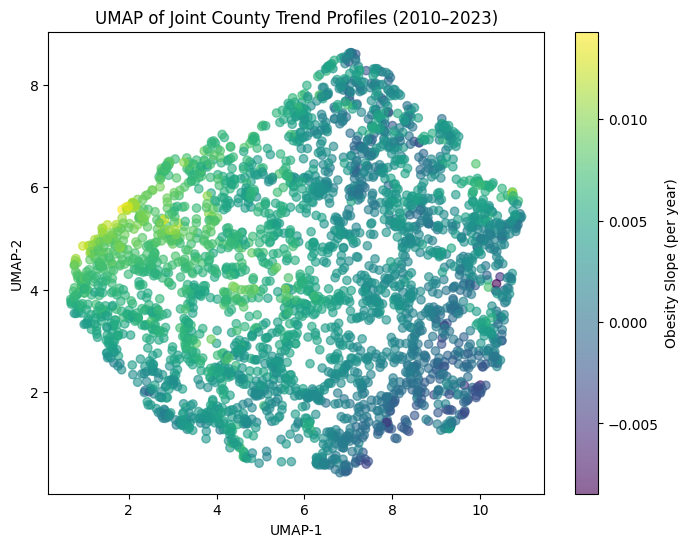

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(
    df_trends["umap_x"],
    df_trends["umap_y"],
    c=df_trends["obesity_slope"],
    cmap="viridis",
    alpha=0.6
)
plt.colorbar(label="Obesity Slope (per year)")
plt.title("UMAP of Joint County Trend Profiles (2010–2023)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

In [14]:
trend_results = []

for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_trend_scaled)

    sil = silhouette_score(X_trend_scaled, labels)
    db  = davies_bouldin_score(X_trend_scaled, labels)
    ch  = calinski_harabasz_score(X_trend_scaled, labels)

    trend_results.append({
        "K": k,
        "silhouette": sil,
        "davies_bouldin": db,
        "calinski_harabasz": ch
    })

trend_results_df = pd.DataFrame(trend_results)
trend_results_df


,K,silhouette,davies_bouldin,calinski_harabasz
0,2,0.202529,1.693959,867.779889
1,3,0.198983,1.572966,807.506158
2,4,0.212322,1.333888,787.615660
3,5,0.195186,1.375858,738.851701
4,6,0.184392,1.340356,697.128520


In [15]:
trend_results_df

,K,silhouette,davies_bouldin,calinski_harabasz
0,2,0.202529,1.693959,867.779889
1,3,0.198983,1.572966,807.506158
2,4,0.212322,1.333888,787.615660
3,5,0.195186,1.375858,738.851701
4,6,0.184392,1.340356,697.128520


In [16]:
best_k = 4

kmeans_trend = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df_trends["trend_cluster"] = kmeans_trend.fit_predict(X_trend_scaled)

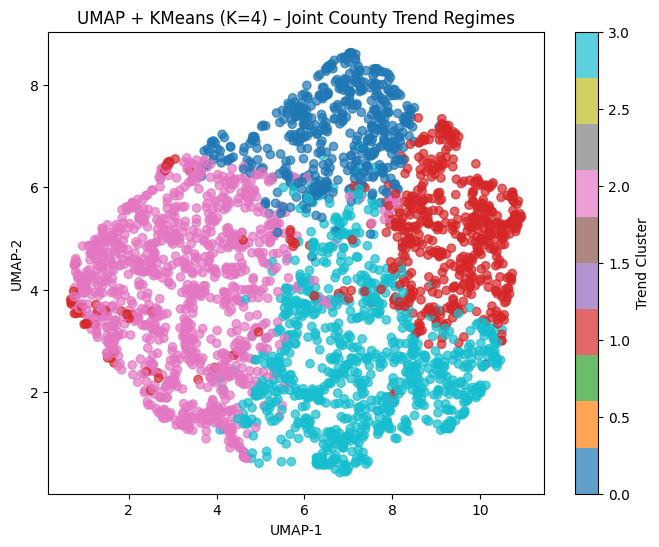

In [17]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_trends["umap_x"],
    df_trends["umap_y"],
    c=df_trends["trend_cluster"],
    cmap="tab10",
    alpha=0.7
)
plt.colorbar(scatter, label="Trend Cluster")
plt.title("UMAP + KMeans (K=4) – Joint County Trend Regimes")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

In [18]:
trend_cluster_summary = (
    df_trends
    .groupby("trend_cluster")[[
        "obesity_slope",
        "inactivity_slope",
        "poverty_slope",
        "income_slope"
    ]]
    .mean()
)

trend_cluster_summary

,obesity_slope,inactivity_slope,poverty_slope,income_slope
trend_cluster,,,,
0,0.003264,-0.001020,-0.001863,2667.798134
1,0.002821,0.000048,-0.004284,1640.376182
2,0.006054,0.001909,-0.001127,1570.577407
3,0.002059,-0.001952,-0.000788,1437.644659


# Automated Pipeline

In [19]:

def evaluate_clustering(X, labels, method_name, param_desc):

    unique_labels = np.unique(labels)
    has_noise = -1 in unique_labels
    n_clusters = len(unique_labels) - (1 if has_noise else 0)

    if n_clusters < 2:
        return {
            "method": method_name,
            "param": param_desc,
            "silhouette": np.nan,
            "calinski": np.nan,
            "davies": np.nan,
            "n_clusters": n_clusters,
            "noise_frac": np.mean(labels == -1) if has_noise else 0,
        }

    mask = labels != -1
    X_valid = X[mask]
    labels_valid = labels[mask]

    sil = silhouette_score(X_valid, labels_valid)
    ch  = calinski_harabasz_score(X_valid, labels_valid)
    db  = davies_bouldin_score(X_valid, labels_valid)

    return {
        "method": method_name,
        "param": param_desc,
        "silhouette": sil,
        "calinski": ch,
        "davies": db,
        "n_clusters": n_clusters,
        "noise_frac": np.mean(labels == -1) if has_noise else 0,
    }

In [20]:
X_weighted_all = X_trend_scaled

In [21]:
def run_and_evaluate_clustering_extended(X_data, evaluate_func):
    results = []
    labels_store = {}


    # 1. KMEANS EXTENDED

    for k in range(2, 10):  # extended from 6 → 10
        for init in ["k-means++", "random"]:
            for max_iter in [300, 500]:
                km = KMeans(
                    n_clusters=k,
                    init=init,
                    max_iter=max_iter,
                    random_state=42,
                    n_init=10
                )
                lab = km.fit_predict(X_data)
                param = f"K={k},init={init},iter={max_iter}"
                res = evaluate_func(X_data, lab, "KMeans", param)
                results.append(res)
                labels_store[("KMeans", param)] = lab


    # 2. AGGLOMERATIVE EXTENDED

    for k in range(2, 10):
        for link in ["ward", "average", "complete"]:
            # ward only works with euclidean
            if link == "ward":
                ag = AgglomerativeClustering(n_clusters=k, linkage="ward")
                lab = ag.fit_predict(X_data)
                param = f"K={k},link={link}"
                res = evaluate_func(X_data, lab, "Agglomerative", param)
                results.append(res)
                labels_store[("Agglomerative", param)] = lab
            else:
                for affinity in ["euclidean", "manhattan"]:
                    ag = AgglomerativeClustering(
                        n_clusters=k,
                        linkage=link,
                        metric=affinity
                    )
                    lab = ag.fit_predict(X_data)
                    param = f"K={k},link={link},aff={affinity}"
                    res = evaluate_func(X_data, lab, "Agglomerative", param)
                    results.append(res)
                    labels_store[("Agglomerative", param)] = lab


    # 3. GMM EXTENDED
    for k in range(2, 10):
        for cov in ["full", "diag", "tied", "spherical"]:
            gmm = GaussianMixture(
                n_components=k,
                covariance_type=cov,
                random_state=42
            )
            lab = gmm.fit_predict(X_data)
            param = f"K={k},cov={cov}"
            res = evaluate_func(X_data, lab, "GMM", param)
            results.append(res)
            labels_store[("GMM", param)] = lab


    # 4. SPECTRAL EXTENDED

    for k in range(2, 10):
        for neighbors in [5, 10, 20]:
            spec = SpectralClustering(
                n_clusters=k,
                n_neighbors=neighbors,
                affinity="nearest_neighbors",
                assign_labels="kmeans",
                random_state=42,
                n_init=10
            )
            lab = spec.fit_predict(X_data)
            param = f"K={k},nn={neighbors}"
            res = evaluate_func(X_data, lab, "Spectral", param)
            results.append(res)
            labels_store[("Spectral", param)] = lab


    # 5. DBSCAN EXTENDED

    for eps in [0.4, 0.5, 0.7, 0.9, 1.1]:
        for ms in [3, 5, 10]:
            for metric in ["euclidean", "manhattan"]:
                db = DBSCAN(
                    eps=eps,
                    min_samples=ms,
                    metric=metric
                )
                lab = db.fit_predict(X_data)
                param = f"eps={eps},ms={ms},met={metric}"
                res = evaluate_func(X_data, lab, "DBSCAN", param)
                results.append(res)
                labels_store[("DBSCAN", param)] = lab


    # 6. HDBSCAN EXTENDED

    for mcs in [10, 20, 40, 60]:
        for ms in [5, 10, 20]:
            hdb = hdbscan.HDBSCAN(
                min_cluster_size=mcs,
                min_samples=ms,
                cluster_selection_method="eom"
            )
            lab = hdb.fit_predict(X_data)
            param = f"mcs={mcs},ms={ms}"
            res = evaluate_func(X_data, lab, "HDBSCAN", param)
            results.append(res)
            labels_store[("HDBSCAN", param)] = lab

    results_df = pd.DataFrame(results).sort_values("silhouette", ascending=False)
    return results_df, labels_store


results_df_all, labels_store_all = run_and_evaluate_clustering_extended(
    X_weighted_all, evaluate_clustering
)

results_df_all.head(15)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

,method,param,silhouette,calinski,davies,n_clusters,noise_frac
34,Agglomerative,"K=2,link=average,aff=manhattan",0.687517,17.459266,0.217182,2,0.000000
33,Agglomerative,"K=2,link=average,aff=euclidean",0.558556,39.094399,0.537963,2,0.000000
39,Agglomerative,"K=3,link=average,aff=manhattan",0.547112,28.470173,0.430758,3,0.000000
44,Agglomerative,"K=4,link=average,aff=manhattan",0.515160,22.045736,0.398561,4,0.000000
38,Agglomerative,"K=3,link=average,aff=euclidean",0.499689,59.945470,0.563421,3,0.000000
152,DBSCAN,"eps=1.1,ms=3,met=euclidean",0.499386,34.191942,0.428054,3,0.010503
49,Agglomerative,"K=5,link=average,aff=manhattan",0.445436,19.854766,0.434142,5,0.000000
54,Agglomerative,"K=6,link=average,aff=manhattan",0.425756,20.748800,0.532142,6,0.000000
43,Agglomerative,"K=4,link=average,aff=euclidean",0.404135,59.968438,0.860514,4,0.000000
154,DBSCAN,"eps=1.1,ms=5,met=euclidean",0.399113,30.593655,0.559443,3,0.015277


In [22]:
def visualize_best_clustering_results(best_row, labels_store, X_weighted, X_umap=None):

    # best_row = results_df.iloc[4]
    best_method, best_param = best_row["method"], best_row["param"]

    print("Best model:", best_method, best_param)
    print(best_row)

    labels_best = labels_store[(best_method, best_param)]

    if best_method.startswith("UMAP") and X_umap is not None:
        plot_X = X_umap
        xlabel, ylabel = "UMAP1", "UMAP2"
    else:
        pca = PCA(n_components=2)
        plot_X = pca.fit_transform(X_weighted)
        xlabel, ylabel = "PC1", "PC2"

    plt.figure(figsize=(8, 6))
    sc = plt.scatter(plot_X[:, 0], plot_X[:, 1],
                     c=labels_best, cmap="tab10", s=18)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"{best_method} ({best_param}) – Cluster Visualization")
    plt.colorbar(sc, label="Cluster")
    plt.show()

    return labels_best



Best model: Agglomerative K=2,link=average,aff=manhattan
method                         Agglomerative
param         K=2,link=average,aff=manhattan
silhouette                          0.687517
calinski                           17.459266
davies                              0.217182
n_clusters                                 2
noise_frac                               0.0
Name: 34, dtype: object


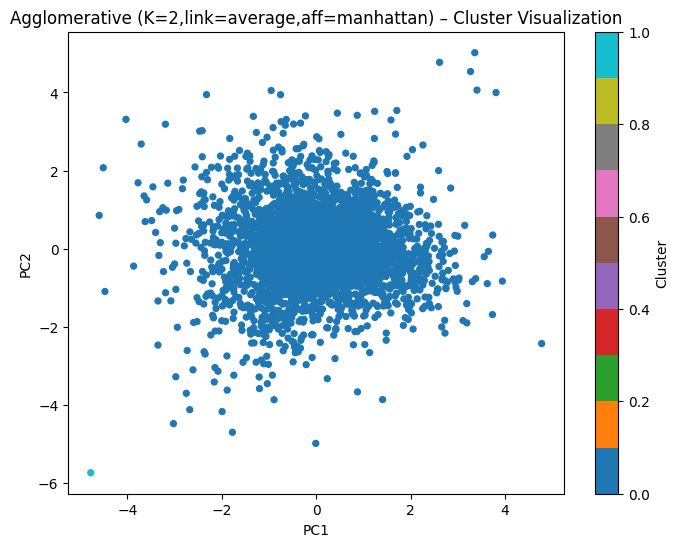

In [23]:
labels_best_all = visualize_best_clustering_results(
    results_df_all.iloc[0], labels_store_all, X_weighted_all
)

In [24]:
df_trends.to_csv("/content/drive/MyDrive/obesity-analytics-notebooks/Multi-Year-Trend/Dataset/county_joint_trends_2010_2023.csv", index=False)

# Data Trend

In [25]:
df["obesity_yoy_change"] = df.groupby("geoid")["obesity_rate"].diff()
df["obesity_yoy_pct"] = df.groupby("geoid")["obesity_rate"].pct_change()

In [26]:
def compute_trend(g):
    years = g["year"].values
    y = g["obesity_rate"].values

    slope = (y[-1] - y[0]) / (years[-1] - years[0])
    volatility = np.nanstd(g["obesity_yoy_change"])

    return pd.Series({
        "obesity_start": y[0],
        "obesity_end": y[-1],
        "obesity_total_change": y[-1] - y[0],
        "obesity_slope_per_year": slope,
        "obesity_volatility": volatility,
        "mean_poverty": g["poverty_rate"].mean(),
        "mean_inactivity": g["physical_inactivity"].mean(),
        "mean_income": g["median_household_income"].mean()
    })

df_trends = df.groupby("geoid").apply(compute_trend).reset_index()


/tmp/ipython-input-2215463858.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_trends = df.groupby("geoid").apply(compute_trend).reset_index()


In [27]:
df_trends["obesity_slope_per_year"].describe()

,obesity_slope_per_year
count,3142.000000
mean,0.003814
std,0.002722
min,-0.008461
25%,0.002077
50%,0.003693
75%,0.005616
max,0.014310


In [28]:
(df_trends["obesity_slope_per_year"] > 0).mean()

np.float64(0.9258434118395926)

In [29]:
df_trends

,geoid,obesity_start,obesity_end,obesity_total_change,obesity_slope_per_year,obesity_volatility,mean_poverty,mean_inactivity,mean_income
0,us-ak-013,0.238036,0.272066,0.034030,0.002618,0.020174,0.161804,0.215890,64932.500000
1,us-ak-110,0.248005,0.307010,0.059005,0.004539,0.014809,0.077858,0.151646,84743.500000
2,us-ak-122,0.275005,0.301002,0.025997,0.002000,0.018683,0.110501,0.212645,65746.142857
3,us-ak-130,0.288015,0.375009,0.086994,0.006692,0.017278,0.100287,0.206294,69075.428571
4,us-ak-150,0.268006,0.301020,0.033014,0.002540,0.022688,0.080644,0.204438,72177.928571
...,...,...,...,...,...,...,...,...,...
3137,us-wy-037,0.285002,0.345007,0.060005,0.004616,0.012910,0.093000,0.234290,72925.142857
3138,us-wy-039,0.138002,0.172006,0.034004,0.002616,0.010762,0.068572,0.114931,89864.357143
3139,us-wy-041,0.299004,0.333021,0.034017,0.002617,0.020218,0.102644,0.233936,65958.285714
3140,us-wy-043,0.228008,0.306043,0.078035,0.006003,0.018341,0.114575,0.221588,54769.714286
